# Neural Networks  - Assignment 1 - a simple implementation 

In this notebook I show how to implement a simple Multi-layer perceptron, a very simple neural network. 

The theory is explained in my notes https://github.com/alexzucca90/Projects/blob/master/Zucca_Alex_NNet_Ass1.pdf

## 1. The multi-layer perceptron (MLP)
Below an implementation of the MLP. It is still not working properly.

In [77]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    
    # Initializing the neural net
    def __init__(self,n_output=1,n_features=2, n_hidden = 2,
                l1=0.0, l2=0.0, max_epochs=100, threshold = 0.05, 
                alpha = 0.1, gamma = 0.0, decrease_const = 0.0, shuffle = True,
                minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self. n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        
        # Regularization params
        self.l1=l1
        self.l2=l2
        
        self.threshold = threshold
        self.max_epochs = max_epochs
        
        #SGD params
        self.alpha = alpha
        self.gamma = gamma
        
        self.decrease_const=decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        
    #then Raschka defines the function _encode_labels. I'll skip it
    
    def _initialize_weights(self):
        # initializing the two weights matrices, w1 for the input layer, w2 for the inner layer
        w1 = np.random.uniform(-0.5,0.5, size=self.n_hidden*(self.n_features+1))
        w1 = w1.reshape(self.n_hidden,self.n_features+1)
        
        w2 = np.random.uniform(-0.5,0.5, size=(self.n_hidden+1)*(self.n_output))
        w2 = w2.reshape(self.n_output,self.n_hidden+1)
        
        return w1, w2
        
    def _activation(self,z):
        return np.tanh(z)
    
    def _activation_gradient(self,z):
        return 1.0 - (np.tanh(z))**2
    
    # then there is the function _add_bias_unit
    def _add_bias_unit(self,X):
        
        X_new = np.ones((X.shape[0]+1,X.shape[1]))
        X_new[1:,:] = X
        return X_new
    
    def _feedforward(self,X,w1,w2):
        # Computing the outputs given the inputs
        # (remember the X here is X_data transposed).
    
        a1 = self._add_bias_unit(X)
        z2 = w1.dot(a1)
        a2 = self._activation(z2)
        a2 = self._add_bias_unit(a2)
        z3 = w2.dot(a2)
        a3 = self._activation(z3)
        
        return a1,z2,a2,z3,a3
    
    def _get_cost(self,y,output):
        errors = y.T - output
        cost = (errors**2).sum()
        return cost

    def _get_gradient(self,a1,z2,a2,z3,a3,y,w1,w2):
        # Back-propagation
        # W.R.T to w2
        grad2 = -((y.T - self._activation(z3))*self._activation_gradient(z3)).dot(a2.T)
        
        #grad1 is a little more complicated and needs some nested for loops
        #Define a matrix B,
        B = -(y.T - self._activation(z3))*self._activation_gradient(z3)
        
        # Initialize the rank-4 tensor C , see my notes
        C = np.zeros((self.n_output, a1.shape[1], self.n_hidden, self.n_features+1))
        # Fill the tensor C now
        for j in range(self.n_output):
            for i in range(a1.shape[1]):
                for m in range(self.n_hidden):
                    for n in range(self.n_features+1):
                        C[j,i,m,n] = w2[j,m+1]*a1[n,i]*self._activation_gradient(z2[m,i])
                        
        # Now initialize grad1
        grad1 = np.zeros((self.n_hidden, self.n_features+1))
        
        # Another nested loop to compute the gradient1
        for m in range(self.n_hidden):
            for n in range(self.n_features+1):
                g = 0
                for i in range(a1.shape[1]):
                    for j in range(self.n_output):
                        g+=B[j,i]*C[j,i,m,n]
                        
                grad1[m,n] = g
                    
        return grad1, grad2
    
    
    # predict function
    def predict(self,X):
        xt = X.T
        a1, z2, a2, z3, a3 = self._feedforward(xt,self.w1, self.w2)
        
        y_pred = z3
        
        return y_pred
    
    # fit function
    def fit(self,X,y,print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        
        #no encode labels
        
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        
        for i in range(self.max_epochs):
            
            # adaptive learning rate? Not yet
            
            if print_progress:
                sys.stderr.write(
                '\rEpoch: %d / %d' %(i+1, self.max_epochs))
                sys.stderr.flush()
                
            # Mixing the things
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y = X_data[idx], y[idx]
                
            mini = np.array_split(range(
            y_data.shape[0]), self.minibatches)
            
            for idx in mini:
                
                #feedforward
                a1,z2,a2,z3,a3 = self._feedforward(
                X_data[idx].T,self.w1, self.w2)
                
                #print('idx:',idx)
                
                cost = self._get_cost(y = y[idx], output=a3)# ,w1=self.w1, w2=self.w2)
                
                self.cost_.append(cost)
                
                # computing the gradients 
                grad1,grad2 = self._get_gradient(a1=a1,z2=z2,a2=a2,z3=z3,a3=a3,
                                                 y=y[idx],w1=self.w1,w2=self.w2)
                
                # update weights
                delta_w1, delta_w2 = self.alpha*grad1, self.alpha*grad2
                self.w1 -= (delta_w1 + (self.gamma*delta_w1_prev))
                self.w2 -= (delta_w2 + (self.gamma*delta_w2_prev))
                
                # storing the previous delta W for the momentum SGD.
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2 

        return self
  

## 2. Defining the training set

In [78]:
X_train = np.array([[-0.5,-0.5], [0.5,-0.5], [-0.5,0.5], [0.5,0.5]])
X_train

array([[-0.5, -0.5],
       [ 0.5, -0.5],
       [-0.5,  0.5],
       [ 0.5,  0.5]])

In [79]:
y_train = np.array([[-0.5],[0.5],[0.5],[-0.5]])
y_train

array([[-0.5],
       [ 0.5],
       [ 0.5],
       [-0.5]])

## 3.  SGD optimization, no momentum, with 2,4,6 hidden layers.

In [127]:
mlp2 = NeuralNetMLP(alpha=0.1, gamma=0, max_epochs=300 ,minibatches=3,n_features=2,n_hidden=2,random_state=42, n_output=1, shuffle=True)

In [128]:
mlp2.fit(print_progress=True,X=X_train,y=y_train)

Epoch: 300 / 300

In [129]:
mlp4=NeuralNetMLP(alpha=0.1, gamma=0,max_epochs=300,minibatches=3,n_features=2,n_hidden=4,random_state=42, n_output=1)

In [130]:
mlp4.fit(print_progress=True,X=X_train,y=y_train)

Epoch: 300 / 300

In [131]:
mlp6=NeuralNetMLP(alpha=0.1, gamma=0,max_epochs=300,minibatches=3,n_features=2,n_hidden=6,random_state=42, n_output=1)

In [132]:
mlp6.fit(print_progress=True,X=X_train,y=y_train)

Epoch: 300 / 300

## 3.1. Results

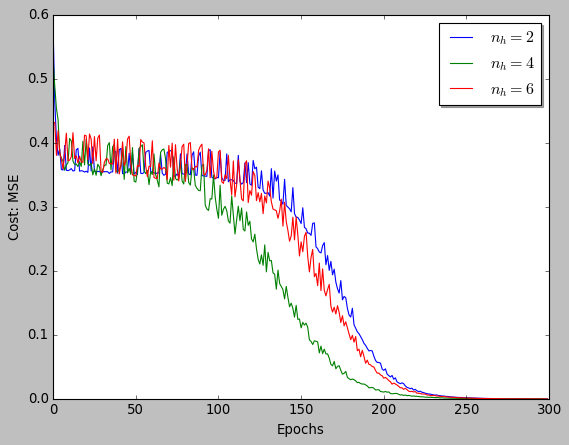

In [133]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pylab as pil

mpl.style.use("classic")
batches2 = np.array_split(range(len(mlp2.cost_)),mlp2.max_epochs)
cost_ary2 = np.array(mlp2.cost_)
cost_avg2 = [np.mean(cost_ary2[i]) for i in batches2]

batches4 = np.array_split(range(len(mlp4.cost_)),mlp4.max_epochs)
cost_ary4 = np.array(mlp4.cost_)
cost_avg4 = [np.mean(cost_ary4[i]) for i in batches4]

batches6 = np.array_split(range(len(mlp6.cost_)),mlp6.max_epochs)
cost_ary6 = np.array(mlp6.cost_)
cost_avg6 = [np.mean(cost_ary6[i]) for i in batches6]

plt.plot(range(len(cost_avg2)), cost_avg2, label = r'$n_h = 2$')
plt.plot(range(len(cost_avg4)), cost_avg4, label = r'$n_h = 4$')
plt.plot(range(len(cost_avg6)), cost_avg6, label = r'$n_h = 6$')
plt.xlabel('Epochs')
plt.ylabel('Cost: MSE')
plt.legend(loc='upper right', shadow=True)
pil.savefig('TEST1.pdf',bbox_inches='tight')
plt.show()

Something is not working yet... Need to check.

## 4. SGD with momentum, and 2,4,6, hidden layers.

In [134]:
mlp2 = NeuralNetMLP(alpha=0.1, gamma=0.9, max_epochs=200 ,minibatches=3,n_features=2,n_hidden=2,random_state=42, n_output=1, shuffle=True)

In [135]:
mlp2.fit(print_progress=True,X=X_train,y=y_train)

Epoch: 200 / 200

In [136]:
mlp4 = NeuralNetMLP(alpha=0.1, gamma=0.9, max_epochs=200 ,minibatches=3,n_features=2,n_hidden=4,random_state=42, n_output=1, shuffle=True)

In [137]:
mlp4.fit(print_progress=True,X=X_train,y=y_train)

Epoch: 200 / 200

In [138]:
mlp6 = NeuralNetMLP(alpha=0.1, gamma=0.9, max_epochs=200 ,minibatches=3,n_features=2,n_hidden=6,random_state=42, n_output=1, shuffle=True)

In [139]:
mlp6.fit(print_progress=True,X=X_train,y=y_train)

Epoch: 200 / 200

### 4.1. Results.

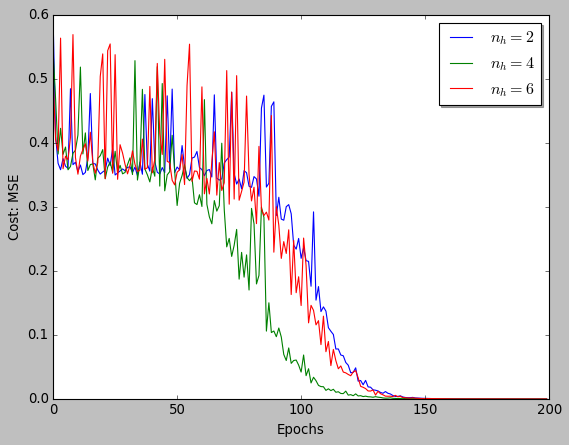

In [140]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pylab as pil

mpl.style.use("classic")
batches2 = np.array_split(range(len(mlp2.cost_)),mlp2.max_epochs)
cost_ary2 = np.array(mlp2.cost_)
cost_avg2 = [np.mean(cost_ary2[i]) for i in batches2]

batches4 = np.array_split(range(len(mlp4.cost_)),mlp4.max_epochs)
cost_ary4 = np.array(mlp4.cost_)
cost_avg4 = [np.mean(cost_ary4[i]) for i in batches4]

batches6 = np.array_split(range(len(mlp6.cost_)),mlp6.max_epochs)
cost_ary6 = np.array(mlp6.cost_)
cost_avg6 = [np.mean(cost_ary6[i]) for i in batches6]

plt.plot(range(len(cost_avg2)), cost_avg2, label = r'$n_h = 2$')
plt.plot(range(len(cost_avg4)), cost_avg4, label = r'$n_h = 4$')
plt.plot(range(len(cost_avg6)), cost_avg6, label = r'$n_h = 6$')
plt.xlabel('Epochs')
plt.ylabel('Cost: MSE')
plt.legend(loc='upper right', shadow=True)
pil.savefig('TEST2.pdf',bbox_inches='tight')
plt.show()